In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# carrego el model vgg19
vgg19 = models.vgg19(pretrained=True).features

# congelo els parametres per evitar modificarlos
for param in vgg19.parameters():
    param.requires_grad = False
    
# carrego el model a la GPU en cas que sigui posible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

# hyperparametres
epochs = 9

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # afegeixo una dimensio ja que el model espera una dimensio de batch
    # que no tenim ja que es tracta d'una unica imatge
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image.to(device)

In [4]:
print(vgg19)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
# funcio per extreure "features" de les imatges utilitzant la vgg19
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',  
            '19': 'conv4_1',
            '21': 'conv4_2',  
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [6]:
# funcio per la calcular la matriu Gram
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [7]:
# carrego les imatges de contingut i estil
content = load_image("prova_contingut.jpg")
style = load_image("prova_estil.jpg", shape=content.shape[2:])

In [8]:
# inicialitzo la imatge "target" com una copia de la imatge contingut
target = content.clone().requires_grad_(True).to(device)
optimizer = optim.LBFGS([target], lr=1, max_iter=20, history_size=10)

In [9]:
# Weights
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2
                 }
content_layer = 'conv4_2'
content_weight = 1  # Ajustar
style_weight = 1e6  # Ajustar

In [10]:
# extrec els mapes de caracteristiques de les imatges de contingut i estil
content_features = get_features(content, vgg19)
style_features = get_features(style, vgg19)
# calculo matrius de Gram
style_grams = {}
for layer in style_weights:
    style_grams[layer] = gram_matrix(style_features[layer])

In [11]:
# funcio de perdues (conté les funcions de perdues de estil i contingut)
def calculate_losses(target_features, content_features, style_grams, style_weights, content_weight, style_weight):
    style_loss = 0
    content_loss = 0
    
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_grams[layer]) ** 2)
        style_loss += layer_style_loss / (target_feature.shape[1] * target_feature.shape[2] * target_feature.shape[3])
    
    
    content_loss = torch.mean((target_features[content_layer] - content_features[content_layer]) ** 2)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    return total_loss

In [12]:
def tensor_to_image(tensor):
    image = tensor.clone().detach().cpu().squeeze()
    image = image.numpy().transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = np.clip(image, 0, 1)
    return image

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0, Total Loss: 307946784.0


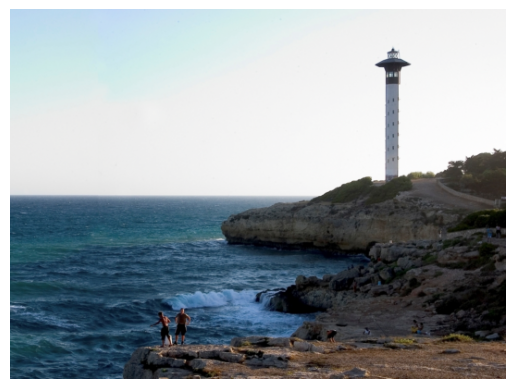

Epoch 2, Total Loss: 18021160.0


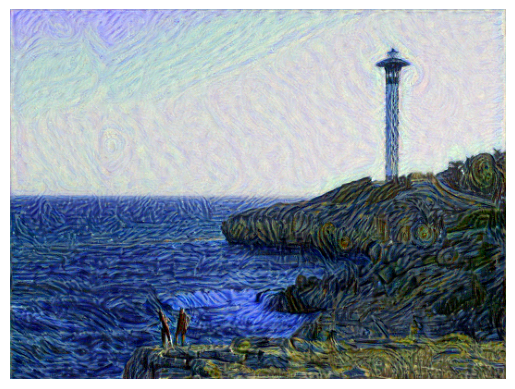

Epoch 4, Total Loss: 2388992.0


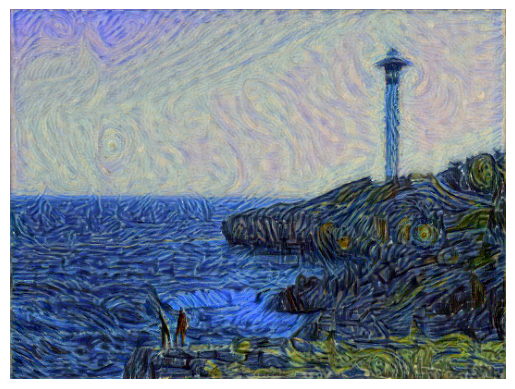

Epoch 6, Total Loss: 718440.3125


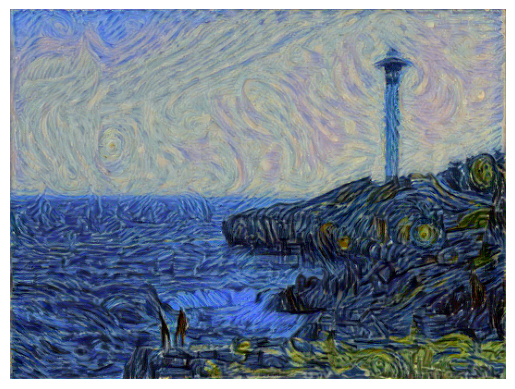

Epoch 8, Total Loss: 351374.625


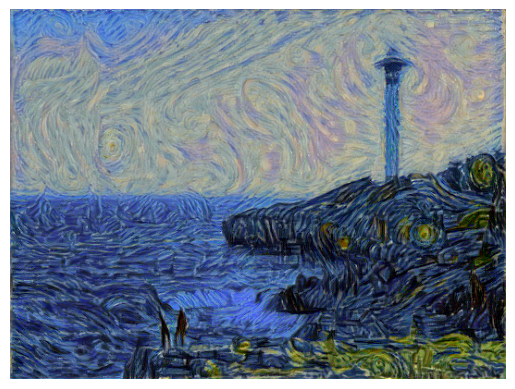

In [13]:
last_loss = None  

for i in tqdm(range(epochs)):
    def closure():
        optimizer.zero_grad()
        target_features = get_features(target, vgg19)
        total_loss = calculate_losses(target_features, content_features, style_grams, style_weights, content_weight, style_weight)
        total_loss.backward()
        return total_loss

    last_loss = optimizer.step(closure)
    
    if i % 2 == 0:
        with torch.no_grad():
            print(f"Epoch {i}, Total Loss: {last_loss.item()}")
            plt.figure()
            plt.imshow(tensor_to_image(target))
            plt.axis('off')
            plt.show()
